# Experience Replay 

## Training with experience replay##


Play game, sample <s,a,r,s'>.

Update q-values based on <s,a,r,s'>.

Store <s,a,r,s'> transition in a buffer.

If buffer is full, delete earliest data.

Sample K such transitions from that buffer and update q-values based on them.

To enable such training, first we must implement a memory structure that would act like such a buffer. 

In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: DISPLAY=:1


'bash' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
import random

class ReplayBuffer(object):
    
    def __init__(self,size):
        self._storage = []
        self._maxsize = size
    
    def __len__(self):
        return len(self._storage)
    
    def add(self, obs_t, action, reward, obs_tp1, done):
        
        data = (obs_t, action, reward, obs_tp1, done)
        
        if len(self._storage) == self._maxsize:
            self._storage = self._storage[1:]
            
        self._storage.append(data)
    
    def sample(self, batch_size):
        
        buffer_size = len(self._storage)
        idxes = np.random.randint(buffer_size, size=batch_size)
        s = []
        a = []
        r = []
        s_next = []
        done = []
        
        for index in idxes:
            s.append(self._storage[index][0])
            a.append(self._storage[index][1])
            r.append(self._storage[index][2])
            s_next.append(self._storage[index][3])
            done.append(self._storage[index][4])
            
        return np.array(s), np.array(a), np.array(r), np.array(s_next), np.array(done)

In [9]:
from qlearning import QLearningAgent

agent_baseline = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

agent_replay = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

replay = ReplayBuffer(10000)

In [24]:
def play_and_train_with_replay(env, agent, replay = None, t_max = 10**4, replay_batch_size = 32):
    
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.get_action(s)
        next_s, r, done, _ = env.step(a)
        
        agent.update(s,a,r,next_s) 
        
        if replay is not None:
            replay.add(s,a,r,next_s, done)
            array_s, array_a, array_r, array_s_next, array_done = replay.sample(replay_batch_size)
            for i in range(replay_batch_size):
                agent.update(array_s[i], array_a[i], array_r[i], array_s_next[i])
                
        s = next_s
        total_reward += r
        if done: break
            
    return total_reward

In [25]:
import gym
env = gym.make('Taxi-v2')
n_actions = env.action_space.n

Baseline : eps = 2.8899181039580177e-05 mean reward = 7.3
ExpReplay: eps = 2.8899181039580177e-05 mean reward = 8.2


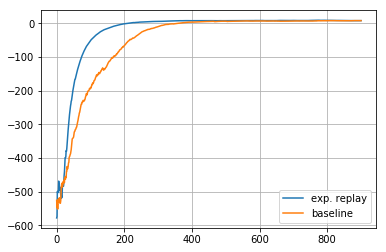

In [27]:
from IPython.display import clear_output
from pandas import DataFrame
moving_average = lambda x, span=100: DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

rewards_replay, rewards_baseline = [],[]

for i in range(1000):
    rewards_replay.append(play_and_train_with_replay(env, agent_replay, replay))
    rewards_baseline.append(play_and_train_with_replay(env, agent_baseline, replay=None))
    
    agent_replay.epsilon *= 0.99
    agent_baseline.epsilon *= 0.99
    
    if i %100 ==0:
        clear_output(True)
        print('Baseline : eps =', agent_replay.epsilon, 'mean reward =', np.mean(rewards_baseline[-10:]))
        print('ExpReplay: eps =', agent_baseline.epsilon, 'mean reward =', np.mean(rewards_replay[-10:]))
        plt.plot(moving_average(rewards_replay), label='exp. replay')
        plt.plot(moving_average(rewards_baseline), label='baseline')
        plt.grid()
        plt.legend()
        plt.show()